In [100]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from IPython.display import HTML

plt.rcParams["figure.dpi"] = 100

In [2]:
df = pd.read_csv("Cars93.csv")
# la primera columna es literalmente el index. Se remueve.
df = df.drop(df.columns[0], axis=1)

# Exploración de variables

Hay tres columnas de "precio". Según [este](https://stat.ethz.ch/R-manual/R-devel/library/MASS/html/Cars93.html) artículo (ya que el link de brightspace no funcionaba), no creo que nos interesen las siguientes columnas:

* `Model` y `Make`: todos son distintos, nada que concluír
* `Min.Price` y `Max.Price`: se usará Price (el promedio de éstos dos)

In [3]:
df = df.drop(["Model","Make","Min.Price","Max.Price"],axis=1)

In [4]:
df.sort_values("Price",ascending=False).head()

,Manufacturer,Type,Price,MPG.city,MPG.highway,AirBags,DriveTrain,Cylinders,EngineSize,Horsepower,...,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Weight,Origin
58,Mercedes-Benz,Midsize,61.9,19,25,Driver & Passenger,Rear,6,3.2,217,...,18.5,5,187,110,69,37,27.0,15.0,3525,non-USA
47,Infiniti,Midsize,47.9,17,22,Driver only,Rear,8,4.5,278,...,22.5,5,200,113,72,42,29.0,15.0,4000,non-USA
10,Cadillac,Midsize,40.1,16,25,Driver & Passenger,Front,8,4.6,295,...,20.0,5,204,111,74,44,31.0,14.0,3935,USA
18,Chevrolet,Sporty,38.0,17,25,Driver only,Rear,8,5.7,300,...,20.0,2,179,96,74,43,NaN,NaN,3380,USA
3,Audi,Midsize,37.7,19,26,Driver & Passenger,Front,6,2.8,172,...,21.1,6,193,106,70,37,31.0,17.0,3405,non-USA


Campos con datos faltantes

In [5]:
null_fields = df.isnull().sum()
null_fields[null_fields != 0]

Rear.seat.room     2
Luggage.room      11
dtype: int64

## tipos de dato de cada variable

De la documentación sabemos que `Cylinders` es realmente numérica (con un dato especial que es `'rotary'`), y `Man.trans.avail` es booleana.

In [7]:
df['Cylinders'] = df['Cylinders'].str.replace('rotary',"nan").apply(float)

In [8]:
columns = df.keys()
types = [type(df[key].iloc[0]).__name__ for key in columns]
column_types_df = pd.DataFrame(zip(columns,types),columns=["field","type"])
ini = "<div style='float:left; margin:10px'>"
HTML(ini + f"</div>{ini}".join([pd.DataFrame({key:val["field"]}).to_html() for key,val in column_types_df.groupby("type")]))

,float64
2,Price
7,Cylinders
8,EngineSize
13,Fuel.tank.capacity
19,Rear.seat.room
20,Luggage.room
,int64
3,MPG.city
4,MPG.highway
9,Horsepower


Son 16 varaibles numéricas, excluyendo `Price`

In [32]:
numeric_columns = column_types_df[column_types_df["type"] != "str"]["field"]
numeric_columns = numeric_columns[numeric_columns != "Price"].values
len(numeric_columns)

16

In [33]:
field_mat = np.reshape(numeric_columns,(4,4))

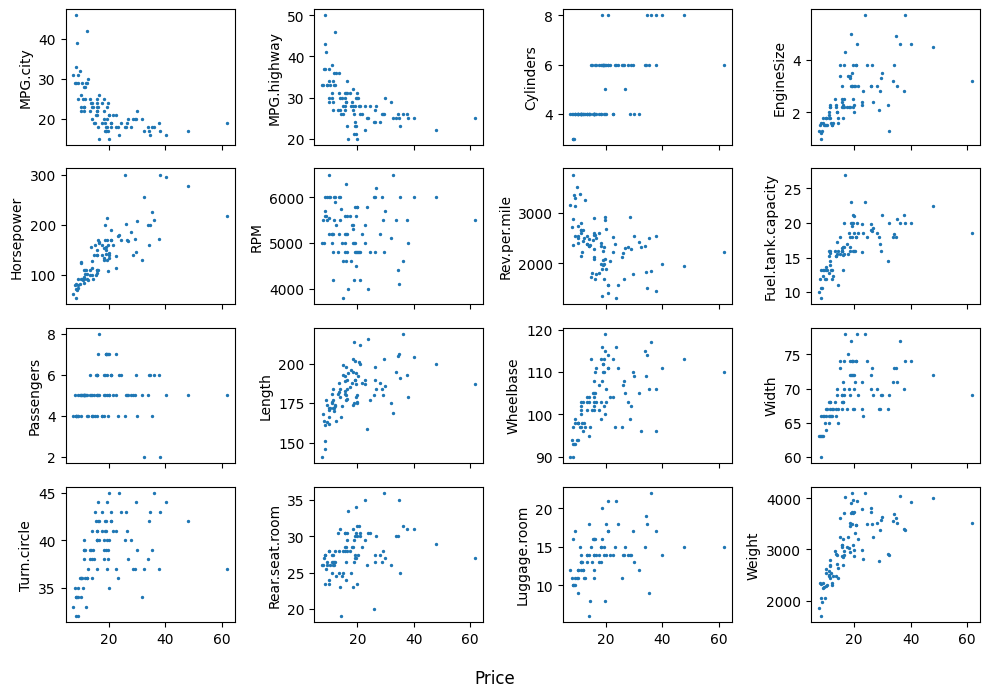

In [34]:
fig, ax = plt.subplots(4,4,sharex=True,figsize=(10,7))

for ij in np.ndindex(4,4):
    plt.sca(ax[ij])
    plt.scatter(df.Price,df[field_mat[ij]],s=2)
    plt.ylabel(field_mat[ij])
    
fig.supxlabel('Price')
plt.tight_layout()

Y 6 varaibles textuales

In [37]:
string_columns = column_types_df[column_types_df["type"] == "str"]["field"].values
len(string_colums)

6

In [38]:
field_mat = np.reshape(string_columns,(2,3))

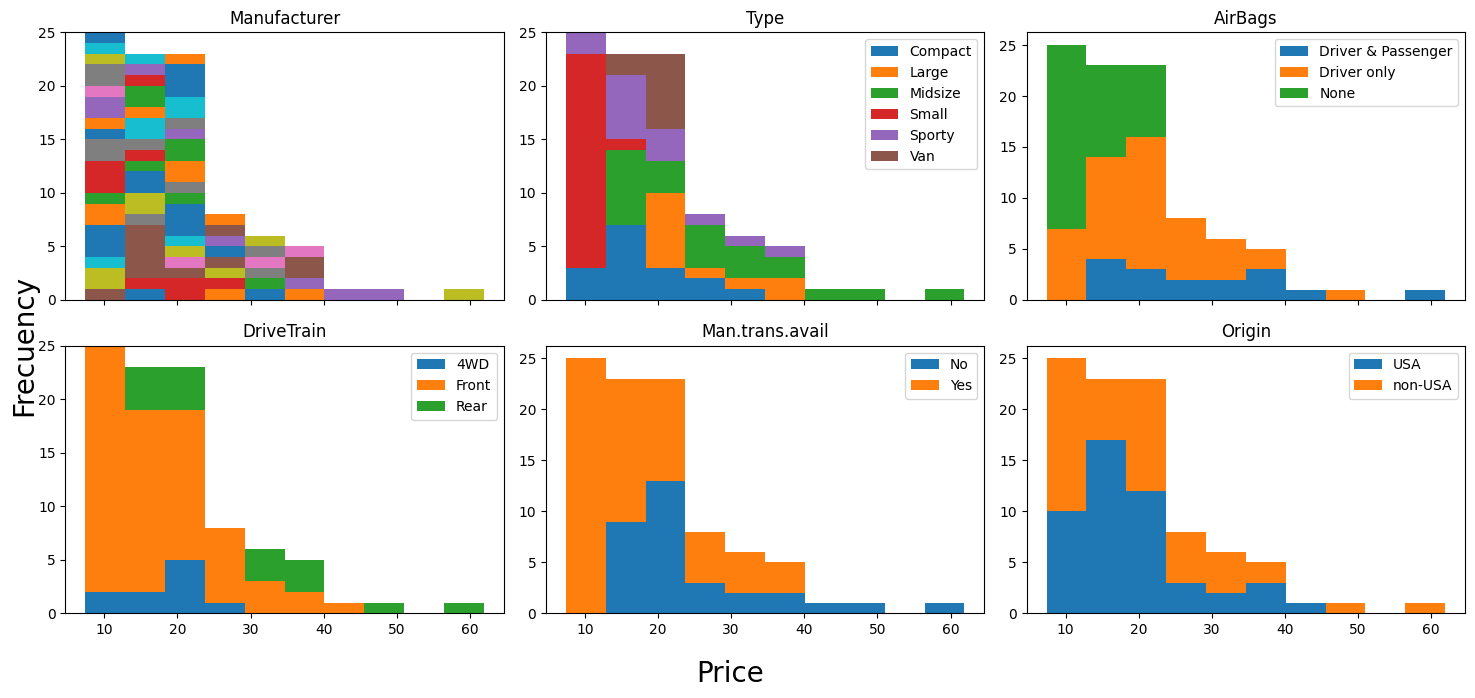

In [44]:
fig,ax = plt.subplots(2,3,sharex=True,figsize=(15,7))

for ij in np.ndindex(2,3):
    
    col = field_mat[ij]
    
    pd.DataFrame(
        {key:np.pad(val.Price.values,(0,93-len(val.Price.values)),'constant',constant_values=np.nan) for key,val in df.groupby(col)}
    ).plot.hist(stacked=True,ax=ax[ij],legend=(col != "Manufacturer"))
    ax[ij].set_title(col)
    ax[ij].set_ylabel("")
    
fig.supxlabel("Price",fontsize=20)
fig.supylabel("Frecuency",fontsize=20)
plt.tight_layout()

ciertamente hay una relación entre estas variables textuales y el precio (excepto en el caso de `Manufacturer`). Las variables booleanas (`Origin` y `Man.trans.avail`) se pondrán como 0 y 1, y los Airbags se pondrán como 0 (None), 1 (driver only) y 2 (driver & passenger). Mirando el historgama de precios, se decidirá que en `DriveTrain` se reemplazará 4WD con 0, Front con 1 y Rear con 2.

In [70]:
df["DriveTrain"] = df["DriveTrain"].str.replace("4WD","0").str.replace("Front","1").str.replace("Rear","2").apply(int)

In [52]:
df["AirBags"] = df["AirBags"].str.replace("None","0").str.replace("Driver only","1").str.replace("Driver & Passenger","2").apply(int)

In [63]:
df["Man.trans.avail"] = (df["Man.trans.avail"] == "Yes")*1

In [68]:
df["Origin"] = (df["Origin"] == "USA")*1

Ahora los tipos son

In [71]:
columns = df.keys()
types = [type(df[key].iloc[0]).__name__ for key in columns]
column_types_df = pd.DataFrame(zip(columns,types),columns=["field","type"])
ini = "<div style='float:left; margin:10px'>"
HTML(ini + f"</div>{ini}".join([pd.DataFrame({key:val["field"]}).to_html() for key,val in column_types_df.groupby("type")]))

,float64
2,Price
7,Cylinders
8,EngineSize
13,Fuel.tank.capacity
19,Rear.seat.room
20,Luggage.room
,int64
3,MPG.city
4,MPG.highway
5,AirBags


Eso significa que todas las variables excepto las dos textuales que quedan serán usadas en el análisis.

In [74]:
train_columns = [key for key in df.keys() if key not in ["Price","Manufacturer","Type"]]

In [101]:
model = RandomForestRegressor()

In [111]:
X_train, X_test, Y_train, Y_test = train_test_split(df[train_columns].fillna(0).values,df.Price.values)

In [112]:
model.fit(X_train,Y_train)

RandomForestRegressor()

In [107]:
Y_predict = model.predict(X_test)

In [116]:
np.array(train_columns)[np.argsort(model.feature_importances_)[::-1]]

array(['Horsepower', 'Weight', 'MPG.city', 'Fuel.tank.capacity',
       'AirBags', 'Length', 'Turn.circle', 'MPG.highway', 'Width',
       'Rear.seat.room', 'Rev.per.mile', 'Wheelbase', 'EngineSize',
       'Luggage.room', 'Cylinders', 'RPM', 'Man.trans.avail', 'Origin',
       'DriveTrain', 'Passengers'], dtype='<U18')